In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sb
import sys
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import urllib
#------------------
sys.path.append("..")
from scripts.dataset import RandomTestDataset
from scripts.models import MLP
from scripts.resnet_family import resnet20_cifar
from scripts.utils_cm import compute_cm

## Softmax probabilites vs model uncertainty

Softmax gives you a notion of confidence for choosing a class over other classes known to the network. 
It does NOT provide you with the uncertainty of the model.

## Evaluate the confidence of the model on unseen categories

In [2]:
# image = image.resize((32, 32))
transform = transforms.Compose([transforms.Resize((32, 32)), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean=[0.491, 0.482, 0.446], std=[0.247, 0.243, 0.261])])
seen_classes = RandomTestDataset('./images/seen_cifar10', transform=transform)
unseen_classes = RandomTestDataset('./images/unseen_cifar10', transform=transform)
seen_dataloader = DataLoader(seen_classes, batch_size=1, shuffle=False)
unseen_dataloader = DataLoader(unseen_classes, batch_size=1, shuffle=False)

In [3]:
labels_cifar10 = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

weights = torch.load('./weights/resnet20.th', map_location=torch.device('cpu'))['state_dict']
model = resnet20_cifar(weights)
model.eval()

seen = []
unseen = []

for i_iter, batch in enumerate(seen_dataloader):
    image, file_name = batch
    output = model(image)
    score, label = F.softmax(output, dim=1).max(1)
    full_file_name = os.path.join('./images/seen_cifar10', file_name[0])
    seen.append({'fname': full_file_name, 'prediction': labels_cifar10[label], 'score': np.round(score.item(), 3)})
    
for i_iter, batch in enumerate(unseen_dataloader):
    image, file_name = batch
    output = model(image)
    score, label = F.softmax(output, dim=1).max(1)
    full_file_name = os.path.join('./images/unseen_cifar10', file_name[0])
    unseen.append({'fname': full_file_name, 'prediction': labels_cifar10[label], 'score': np.round(score.item(), 3)})

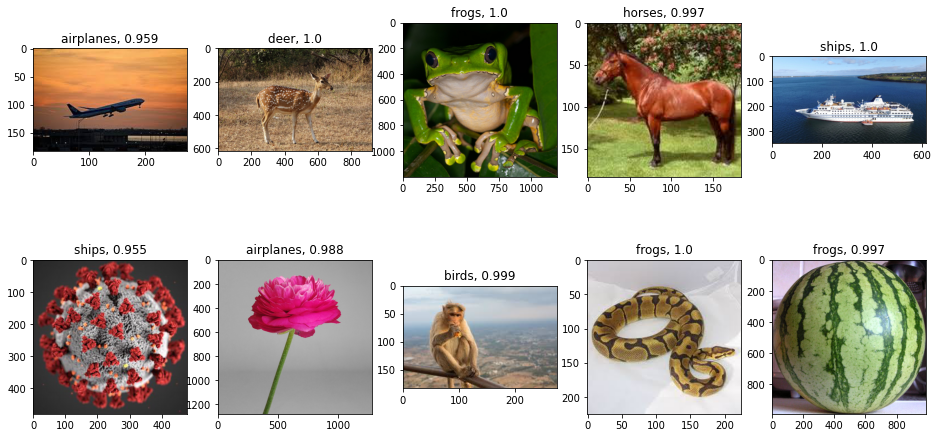

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i in range(len(seen)):
    image = Image.open(seen[i]['fname'])
    ax[0, i].imshow(image)
    ax[0, i].set_title(f"{seen[i]['prediction']}, {seen[i]['score']}")
    image = Image.open(unseen[i]['fname'])
    ax[1, i].imshow(image)
    ax[1, i].set_title(f"{unseen[i]['prediction']}, {unseen[i]['score']}")

# Model Uncertainty

The idea of computing model uncertainty is to find out what the model does Not know. Then we should be more hesitant making decisions on thoses cases. As an example, when you train a machine learning model using either Maximum-Likelihood or Maximum-a-Posteriory algorithm, you end up with a point estimate for the model parameters $\theta^*$. This leads to a fixed leanred model $h(\theta^*)$, that always maps an input sample $x_0$ to $y_0 = h(x_0; \theta^*)$. 

What if for a reason (for example staying on a saddle point in the parameters space) that mapping is not reliable and the model is very sensitive to small deviations of the input data? What might happen is that we might get $y_1 = h(x_1; \theta^*)$ , where $y_1$ is far off from $y_0$, despite the fact that $\|x_1 - x_0\| < \epsilon$.

This is where embedding prior knowledge into the models (most commonly using Bayesian Learning/Inference) comes into play. The idea of Bayesian learning is to account for different possibilities for the model parameters rather than relying on some point estimates weights (which are offsprings of the MLE/MAP algorithms). These different possibilities are normally encoded using prior knowledge that is bound to the model parameters/weight. They are often defined as prior distributions over the parameters and used during model training, and then at the inference time, a set of parameters are sampled from their pre-definde distributions and used for making predictions.

A natural extension of using Bayesian inference is thatthe models learned this way can be seamlessly used for ensemble predictions; I.e no extra training is required to produce multiple models, you just run the model with different prior samplings and get slightly different results, which is what proposed in this paper [YarinGalEtal-2016](http://proceedings.mlr.press/v48/gal16.pdf). We can treat these different outputs as different empirical samples from our approximate predictive posterior.

Another advantage of Bayesian learning is that we don't need to worry that much about hyper-parameter optimisation and the state of the weights when training stops, because at the inference time we just integrate over the entire distribution of the parameters. This however is computationally interactable and we almost always would need to settle with approximate inference.

## Gaussian Processes, Bayesian Optimisation, and Bayesian NNs using DropOut

### Good reads (and watch):
[A Tutorial on Bayesian Optimization of Expensive Cost Functions](docs/BayesianOptimisation.pdf)

[What My Deep Model Doesn't Know](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html)

[Leveraging uncertainty information from deep neural networks for disease detection](docs/BayesianDNN_nature_eye_disease.pdf)

[Bayesian CNNs](https://arxiv.org/pdf/1506.02158.pdf)

[Uncertainty Quantification and Deep Learning, Elise Jennings](https://www.youtube.com/watch?v=Puc_ujh5QZs)

### Resemblance of Bayesian Neural networks and Gaussian Processes

A single layer wide neural network with infinite number of neurons and probability distributions over the weights is mathematically equivalent to a Gaussian Process [Priors for Infinite Networks](https://www.cs.toronto.edu/~radford/ftp/pin.pdf), [Deep Neural Networks as Gaussian Processes](https://openreview.net/pdf?id=B1EA-M-0Z).

## Experiments on MNIST

We build a shallow network and test it in MNST data, and run some experiments similar to what shown in [here](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) and [here](https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/).

### Preparing the dataset

In [5]:
batch_size = 64
mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Train Set:
mnist_train_dataset = torchvision.datasets.MNIST('./data/', train=True, download=True, transform=mnist_transform)
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
# Test Set:
mnist_test_dataset = torchvision.datasets.MNIST('./data/', train=False, download=True, transform=mnist_transform)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


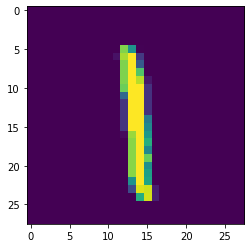

In [6]:
sample_data = next(enumerate(mnist_train_loader))
sample_data = sample_data[1][0].view(batch_size, 784)[0, :].view(28, 28).data.numpy()
plt.imshow(sample_data)

### Build the model (without DropOut) and configure the training

In [7]:
mlp = MLP(input_size=28*28, nclasses=10, hidden_layers=[800, 800], dropout=0, dropout_input=0)
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
mlp.net

Sequential(
  (0): Linear(in_features=784, out_features=800, bias=True)
  (1): ReLU6()
  (2): Linear(in_features=800, out_features=800, bias=True)
  (3): ReLU6()
  (4): Linear(in_features=800, out_features=10, bias=True)
)

In [8]:
n_epochs = 10
loss_value = 0
reset_loss_every = 300
device = "cpu"

In [9]:
for epoch in range(n_epochs):
    for it, train_batch in enumerate(mnist_train_loader):
        mlp.train()
        
        images, train_labels_batch = train_batch
        train_data_batch = images.view(train_labels_batch.shape[0], 784)
        output = mlp(train_data_batch)
        optimizer.zero_grad()
        loss = F.cross_entropy(output, train_labels_batch.to(device), reduction="mean")
        
        loss.backward()
        loss_value += loss.item()
        optimizer.step()
        
        if (it % reset_loss_every) == 0 and it > 0:
            print(f"epoch: {epoch}, iteration: {it}, loss_value: {loss_value/reset_loss_every}")
            loss_value = 0

epoch: 0, iteration: 300, loss_value: 0.5114704906443754
epoch: 0, iteration: 600, loss_value: 0.20105272099996607
epoch: 0, iteration: 900, loss_value: 0.1469336283765733
epoch: 1, iteration: 300, loss_value: 0.12413744830836852
epoch: 1, iteration: 600, loss_value: 0.09481435043737292
epoch: 1, iteration: 900, loss_value: 0.0830515681952238
epoch: 2, iteration: 300, loss_value: 0.07704239866385858
epoch: 2, iteration: 600, loss_value: 0.06156152812453608
epoch: 2, iteration: 900, loss_value: 0.06168099374820789
epoch: 3, iteration: 300, loss_value: 0.04912795019336045
epoch: 3, iteration: 600, loss_value: 0.04450273518683389
epoch: 3, iteration: 900, loss_value: 0.048265891869862874
epoch: 4, iteration: 300, loss_value: 0.03650273102878903
epoch: 4, iteration: 600, loss_value: 0.03283419877756387
epoch: 4, iteration: 900, loss_value: 0.03270423705573194
epoch: 5, iteration: 300, loss_value: 0.026899952076297876
epoch: 5, iteration: 600, loss_value: 0.024101003596248727
epoch: 5, iter

### Evaluating on the test set

In [10]:
mlp.eval()
gt_test, preds_test = [], []
for it_test, test_batch in enumerate(mnist_test_loader):
    images, test_labels_batch = test_batch
    test_data_batch = images.view(test_labels_batch.shape[0], 784)
    output_test = mlp(test_data_batch.to(device).float())
    preds_test.append(F.softmax(output_test, dim=1).data.numpy())
    gt_test.append(test_labels_batch.numpy())
preds_test = np.vstack(preds_test)
preds_test_labels = preds_test.argmax(-1)
preds_test_score = preds_test.max(-1)
gt_test = np.hstack(gt_test)
recall, precision = compute_cm(gt_test, preds_test_labels, classes=range(10))
print(f'average recall: {recall.mean()},  average precision: {precision.mean()}')
preds_test.shape

average recall: 0.982,  average precision: 0.9830000000000002


(10000, 10)

### Filter the incorrectly classified images

In [11]:
preds_test_score_threshold = 0.5
wrong_samples = np.where(np.logical_and(gt_test != preds_test_labels, preds_test_score > preds_test_score_threshold))[0]
wrong_samples_labels = preds_test_labels[wrong_samples]
wrong_samples_scores = preds_test_score[wrong_samples]
wrong_samples_gt = gt_test[wrong_samples]
wrong_samples_gt

array([4, 4, 9, 2, 5, 3, 6, 8, 8, 2, 7, 5, 4, 9, 0, 8, 6, 4, 3, 7, 6, 7,
       4, 9, 7, 5, 8, 7, 5, 2, 6, 7, 7, 8, 4, 9, 0, 3, 8, 7, 9, 7, 2, 0,
       7, 1, 7, 2, 4, 2, 3, 4, 6, 1, 5, 8, 2, 9, 8, 3, 2, 5, 5, 7, 9, 6,
       7, 4, 7, 3, 3, 9, 3, 1, 5, 7, 4, 6, 9, 6, 5, 8, 9, 4, 8, 5, 4, 2,
       7, 0, 6, 5, 1, 4, 0, 9, 9, 2, 7, 2, 8, 2, 6, 7, 3, 9, 8, 6, 0, 2,
       0, 1, 7, 1, 4, 3, 9, 4, 5, 3, 5, 3, 5, 3, 3, 3, 3, 1, 9, 0, 8, 9,
       0, 0, 1, 6, 0, 1, 1, 1, 1, 2, 3, 8, 0, 8, 8, 4, 7, 7, 7, 8, 9, 1,
       9, 0, 6, 5, 5, 9, 2, 3])

In [12]:
wrong_subset = torch.utils.data.Subset(mnist_test_dataset, wrong_samples)
wrong_subset_loader = DataLoader(wrong_subset, batch_size=1, shuffle=False)

### And some correct ones

In [13]:
preds_test_score_threshold = 0.5
right_samples = np.where(np.logical_and(gt_test == preds_test_labels, preds_test_score > preds_test_score_threshold))[0]
right_samples_labels = preds_test_labels[right_samples]
right_samples_scores = preds_test_score[right_samples]
right_samples_gt = gt_test[right_samples]
right_samples_gt

array([7, 2, 1, ..., 4, 5, 6])

In [14]:
right_subset = torch.utils.data.Subset(mnist_test_dataset, right_samples)
right_subset_loader = DataLoader(right_subset, batch_size=1, shuffle=False)

## Re-evaluate those images, but with active DropOut 

### First re-train the model, with DropOut enabled.

In [15]:
mlp_dropout = MLP(input_size=28*28, nclasses=10, hidden_layers=[800, 800], dropout=0.5, dropout_input=0.2)
optimizer = torch.optim.SGD(mlp_dropout.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
mlp_dropout.net

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=784, out_features=800, bias=True)
  (2): ReLU6()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=800, out_features=800, bias=True)
  (5): ReLU6()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=800, out_features=10, bias=True)
)

In [16]:
n_epochs = 10
loss_value = 0
reset_loss_every = 300
device = "cpu"

for epoch in range(n_epochs):
    for it, train_batch in enumerate(mnist_train_loader):
        mlp_dropout.train()
        
        images, train_labels_batch = train_batch
        train_data_batch = images.view(train_labels_batch.shape[0], 784)
        output = mlp_dropout(train_data_batch)
        optimizer.zero_grad()
        loss = F.cross_entropy(output, train_labels_batch.to(device), reduction="mean")
        
        loss.backward()
        loss_value += loss.item()
        optimizer.step()
        
        if (it % reset_loss_every) == 0 and it > 0:
            print(f"epoch: {epoch}, iteration: {it}, loss_value: {loss_value/reset_loss_every}")
            loss_value = 0

epoch: 0, iteration: 300, loss_value: 0.6612515413761139
epoch: 0, iteration: 600, loss_value: 0.31607678381105264
epoch: 0, iteration: 900, loss_value: 0.24477495972067118
epoch: 1, iteration: 300, loss_value: 0.2303623795012633
epoch: 1, iteration: 600, loss_value: 0.20175570845603943
epoch: 1, iteration: 900, loss_value: 0.17371230237806837
epoch: 2, iteration: 300, loss_value: 0.17705541649833323
epoch: 2, iteration: 600, loss_value: 0.1508417511296769
epoch: 2, iteration: 900, loss_value: 0.1533576329983771
epoch: 3, iteration: 300, loss_value: 0.1454419541048507
epoch: 3, iteration: 600, loss_value: 0.12725531426568826
epoch: 3, iteration: 900, loss_value: 0.12517489027542372
epoch: 4, iteration: 300, loss_value: 0.13501760414491096
epoch: 4, iteration: 600, loss_value: 0.1138239242726316
epoch: 4, iteration: 900, loss_value: 0.1197567915606002
epoch: 5, iteration: 300, loss_value: 0.1176331948209554
epoch: 5, iteration: 600, loss_value: 0.11027932145943244
epoch: 5, iteration: 9

### Compute the uncertainties for the images with wrong standard Softmax classification results

We compute the uncertainties for the images with incorrect classification results.
* Evaluate each image 100 times, while DropOut is switched on.
* Pick the label with the largest average softmax probability
* Predictive_mean = mean of the label score over the 100 runs
* Predictive_std = standard deviation of the label score over the 100 runs

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


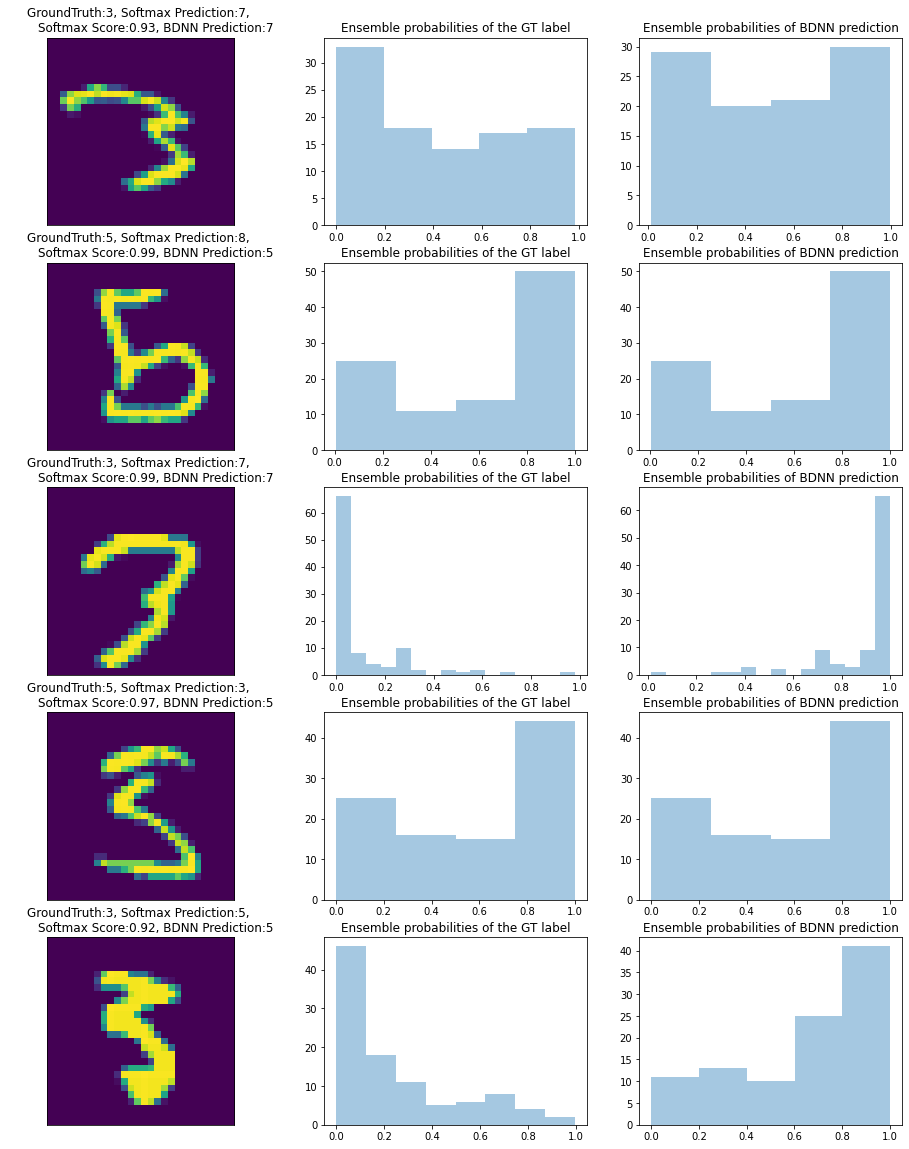

In [17]:
mlp_dropout.train()

ensemble_size = 100

number_of_rows = 5
idx = 0
fig, axes = plt.subplots(number_of_rows, 3, figsize=(16, 20 * number_of_rows // 5))
for it, test_batch in enumerate(wrong_subset_loader):
    images, target = test_batch
    if target.item() not in (3, 5):
        continue
    scores = []
    for _ in range(ensemble_size):
        test_data_batch = images.view(target.shape[0], 784)
        output_test = mlp_dropout(test_data_batch.to(device).float())
        scores.append(F.softmax(output_test, dim=1).data.numpy())
    scores = np.vstack(scores)
    label = scores.mean(axis=0).argmax(0)
    predictive_mean = np.round(np.mean(scores[:, label]), 2)
    predictive_std = np.round(np.std(scores[:, label]), 2)
    
    if wrong_samples_scores[it] > 0.90:
        img = images[0, 0].data.numpy()
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f"""GroundTruth:{target.item()}, Softmax Prediction:{wrong_samples_labels[it]}, 
        Softmax Score:{str(np.around(wrong_samples_scores[it], 2))}, BDNN Prediction:{label}""")
        axes[idx, 0].xaxis.set_visible(False)
        axes[idx, 0].yaxis.set_visible(False)
        axes[idx, 0].xaxis.set_ticks([])
        axes[idx, 0].yaxis.set_ticks([])
        sb.distplot(scores[:, target.item()], kde=False, kde_kws={'clip': (0.0, 1.0)}, ax=axes[idx, 1])
        axes[idx, 1].set_title(f"Ensemble probabilities of the GT label")
        sb.distplot(scores[:, label], kde=False, kde_kws={'clip': (0.0, 1.0)}, ax=axes[idx, 2])
        axes[idx, 2].set_title(f"Ensemble probabilities of BDNN prediction")
        idx += 1
    if idx == number_of_rows:
        break


For example the top row shows that even though the image with correct number of *3* has been predicted as *7* with a high output probability of 0.93, our netwotk is quite uncertain about it. As we can see in the right most figure, only 30 runs out of 100 ensemble have oredicted this image as *7* with a probability of larger than 0.8, and all other runs have a much lower probability scores for this incorrect class. Note that by looking at this example, we can understand why the network has picked *7* as the output, but at least our ensemble method can reveal its uncertainty. The same story goes for the other rows as well, since the network is not quite certain about its predictions, it does not produce consistent high probabilities for all 100 ensembles.

#### Compare the softmax scores with the ensemble mean and standard deviations

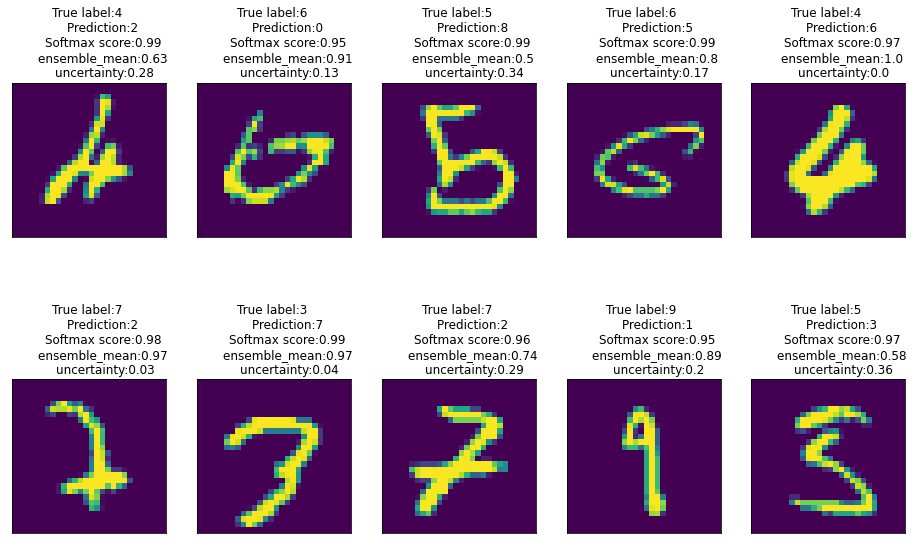

In [22]:
mlp_dropout.train()
ensemble_size = 10

predictive_mean_total_wrong = []
predictive_std_total_wrong = []
softmax_total_wrong = []

idx = 0
fig, axes = plt.subplots(2, 5, figsize=(16, 10))
for it, test_batch in enumerate(wrong_subset_loader):
    images, target = test_batch
    scores = []
    for _ in range(ensemble_size):
        test_data_batch = images.view(target.shape[0], 784)
        output_test = mlp_dropout(test_data_batch.to(device).float())
        scores.append(F.softmax(output_test, dim=1).data.numpy())
    scores = np.vstack(scores)
    label = scores.mean(axis=0).argmax(0)
    predictive_mean = np.round(np.mean(scores[:, label]), 2)
    predictive_std = np.round(np.std(scores[:, label]), 2)
    
    predictive_mean_total_wrong.append(predictive_mean)
    predictive_std_total_wrong.append(predictive_std)
    softmax_total_wrong.append(np.around(wrong_samples_scores[it], 2))
    
    if idx < 10 and wrong_samples_scores[it] > 0.95:
        img = images[0, 0].data.numpy()
        axes[idx//5, idx%5].imshow(img)
        axes[idx//5, idx%5].set_title(f"""True label:{target.item()} 
        Prediction:{wrong_samples_labels[it]} 
        Softmax score:{str(np.around(wrong_samples_scores[it], 2))} 
        ensemble_mean:{str(predictive_mean)} 
        uncertainty:{str(predictive_std)}""")
        axes[idx//5, idx%5].xaxis.set_visible(False)
        axes[idx//5, idx%5].yaxis.set_visible(False)
        axes[idx//5, idx%5].xaxis.set_ticks([])
        axes[idx//5, idx%5].yaxis.set_ticks([])
        idx += 1

predictive_mean_total_wrong = np.array(predictive_mean_total_wrong)
predictive_std_total_wrong = np.array(predictive_std_total_wrong)
softmax_total_wrong = np.array(softmax_total_wrong)

### Check the uncertainty and predictive mean of top correct images

In [24]:
correct_samples = np.where(np.logical_and(gt_test == preds_test_labels, preds_test_score > preds_test_score_threshold))[0]
correct_samples_labels = preds_test_labels[correct_samples]
correct_samples_scores = preds_test_score[correct_samples]
correct_samples.shape

(9805,)

In [25]:
mlp_dropout.train()

predictive_mean_total_correct = []
predictive_std_total_correct = []
softmax_total_correct = []

correct_subset = torch.utils.data.Subset(mnist_test_dataset, correct_samples)
correct_subset_loader = DataLoader(correct_subset, batch_size=1, shuffle=False)

# fig, axes = plt.subplots(2, 5, figsize=(16, 10))
for it, test_batch in enumerate(correct_subset_loader):
    images, target = test_batch
    scores = []
    for _ in range(ensemble_size):
        test_data_batch = images.view(target.shape[0], 784)
        output_test = mlp_dropout(test_data_batch.to(device).float())
        scores.append(F.softmax(output_test, dim=1).data.numpy())
    scores = np.vstack(scores)
    label = scores.mean(axis=0).argmax(0)
    predictive_mean = np.round(np.mean(scores[:, label]), 2)
    predictive_std = np.round(np.std(scores[:, label]), 2)
    
    predictive_mean_total_correct.append(predictive_mean)
    predictive_std_total_correct.append(predictive_std)
    softmax_total_correct.append(np.around(correct_samples_scores[it], 2))
    
#     if it < 10:
#         img = images[0, 0].data.numpy()
#         axes[it//5, it%5].imshow(img)
#         axes[it//5, it%5].set_title(f"""True label:{target.item()} 
#         Softmax score:{str(np.around(correct_samples_scores[it], 2))} 
#         ensemble_mean:{str(predictive_mean)} 
#         uncertainty:{str(predictive_std)}""")
#         axes[it//5, it%5].xaxis.set_visible(False)
#         axes[it//5, it%5].yaxis.set_visible(False)
#         axes[it//5, it%5].xaxis.set_ticks([])
#         axes[it//5, it%5].yaxis.set_ticks([])
        
predictive_mean_total_correct = np.array(predictive_mean_total_correct)
predictive_std_total_correct = np.array(predictive_std_total_correct)
softmax_total_correct = np.array(softmax_total_correct)    

#### Compare the uncertainty of our correct and incorrect predictions

In [26]:
uncertainty_threshold = .2
metric_wrong = predictive_std_total_wrong #* (1-predictive_mean_total_wrong)
metric_correct = predictive_std_total_correct #* (1-predictive_mean_total_correct)
uncertain_correct = np.where(metric_correct > uncertainty_threshold)[0]
uncertain_wrong = np.where(metric_wrong > uncertainty_threshold)[0]
correct_ratio = np.round(100*len(uncertain_correct) / len(metric_correct), 2)
wrong_ratio = np.round(100*len(uncertain_wrong) / len(metric_wrong), 2)
print(f"{correct_ratio}% of the correct predictions have uncertainty > {uncertainty_threshold}")
print(f"{wrong_ratio}% of the wrong predictions have uncertainty > {uncertainty_threshold}")

7.1% of the correct predictions have uncertainty > 0.2
75.93% of the wrong predictions have uncertainty > 0.2


### Compute the uncertainties for the correct results

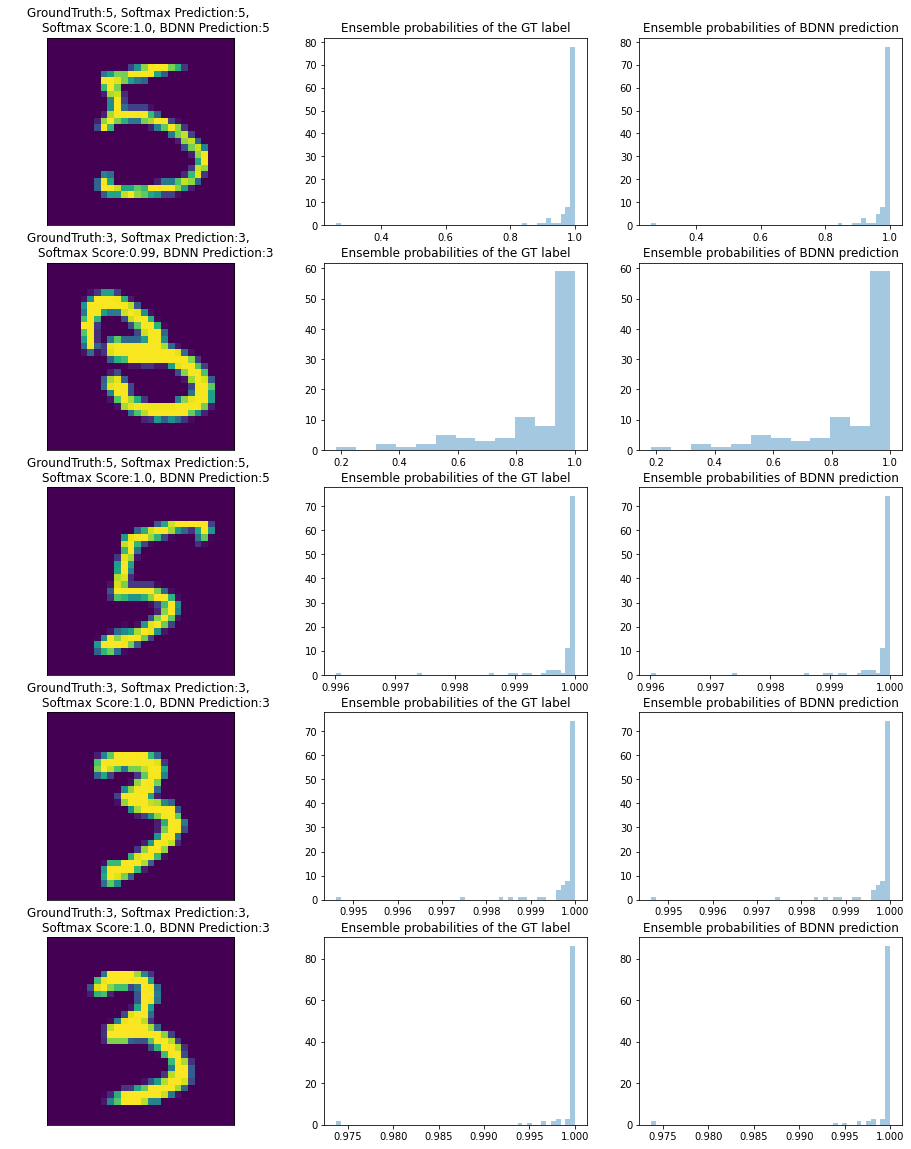

In [27]:
mlp_dropout.train()

ensemble_size = 100

number_of_rows = 5
idx = 0
fig, axes = plt.subplots(number_of_rows, 3, figsize=(16, 20 * number_of_rows // 5))
for it, test_batch in enumerate(right_subset_loader):
    images, target = test_batch
    if target.item() not in (3, 5):
        continue
    scores = []
    for _ in range(ensemble_size):
        test_data_batch = images.view(target.shape[0], 784)
        output_test = mlp_dropout(test_data_batch.to(device).float())
        scores.append(F.softmax(output_test, dim=1).data.numpy())
    scores = np.vstack(scores)
    label = scores.mean(axis=0).argmax(0)
    predictive_mean = np.round(np.mean(scores[:, label]), 2)
    predictive_std = np.round(np.std(scores[:, label]), 2)
    
    if right_samples_scores[it] > 0.95:
        img = images[0, 0].data.numpy()
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f"""GroundTruth:{target.item()}, Softmax Prediction:{right_samples_labels[it]}, 
        Softmax Score:{str(np.around(right_samples_scores[it], 2))}, BDNN Prediction:{label}""")
        axes[idx, 0].xaxis.set_visible(False)
        axes[idx, 0].yaxis.set_visible(False)
        axes[idx, 0].xaxis.set_ticks([])
        axes[idx, 0].yaxis.set_ticks([])
        sb.distplot(scores[:, target.item()], kde=False, kde_kws={'clip': (0.0, 1.0)}, ax=axes[idx, 1])
        axes[idx, 1].set_title(f"Ensemble probabilities of the GT label")
        sb.distplot(scores[:, label], kde=False, kde_kws={'clip': (0.0, 1.0)}, ax=axes[idx, 2])
        axes[idx, 2].set_title(f"Ensemble probabilities of BDNN prediction")
        idx += 1
    if idx == number_of_rows:
        break


In contrast to the incorrect prediction outputs, in the above cell, we are dealing with some images where the model is very certain with low variance in terms of 100 ensemble predictions and in almost all of them, the probability of the predictions are very close to one. This shows that the model has a high confidence in its prediction for these images.

## Test the MNIST model on Fashion-MNIST dataset

Let's go back to ourinitial problem, which was testing a trained model on an irrelevant dataset.
We saw at the beginning of this notebook that softmax produces highly saturated scores for meaningless predictions.
Now we check our dropout uncertainty extimator to find the uncertainty of MNIST digit classifier tested on Fashion dataset.

In [28]:
batch_size = 1
fmnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.28604105,), (0.35302445,))])
fmnist_train_dataset = torchvision.datasets.FashionMNIST('./data/', train=True, download=True, transform=fmnist_transform)
fmnist_train_loader = DataLoader(fmnist_train_dataset, batch_size=batch_size, shuffle=True)

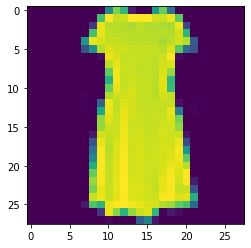

In [29]:
sample_data = next(enumerate(fmnist_train_loader))
sample_data = sample_data[1][0].view(batch_size, 784)[0, :].view(28, 28).data.numpy()
plt.imshow(sample_data)

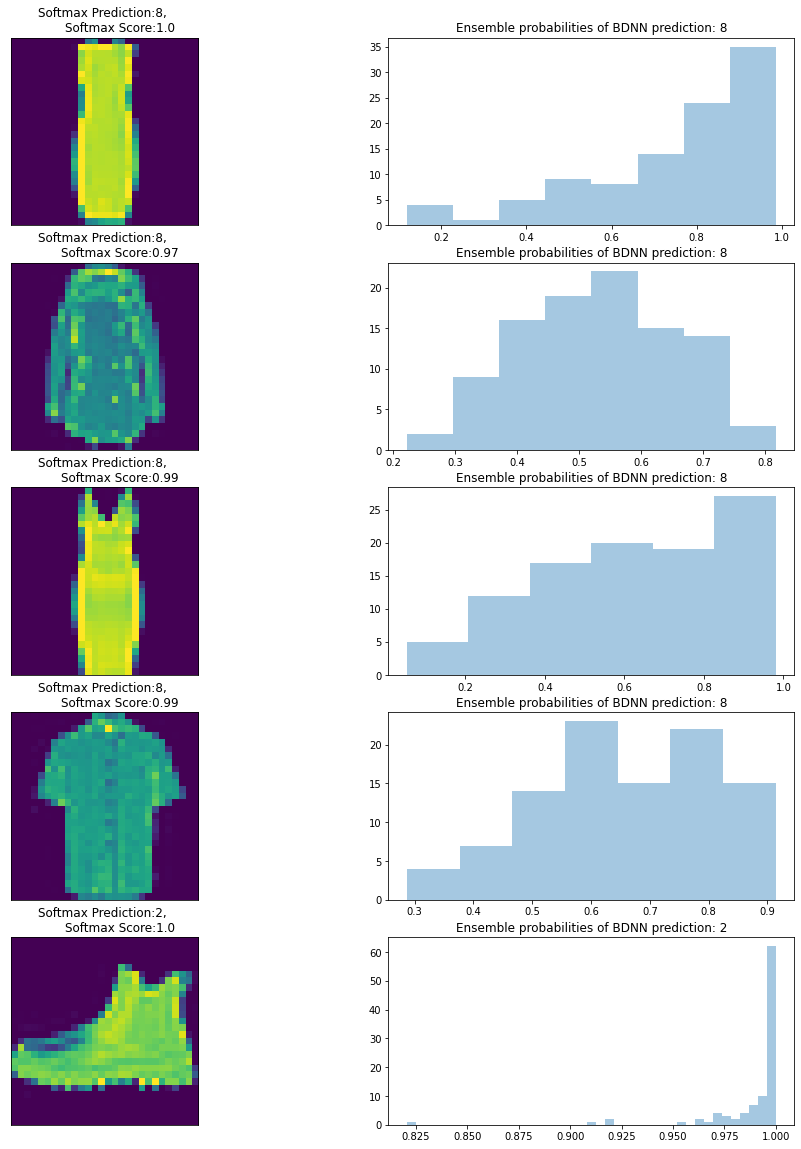

In [30]:
mlp_dropout.train()
mlp.eval()

ensemble_size = 100

number_of_rows = 5
idx = 0
fig, axes = plt.subplots(number_of_rows, 2, figsize=(16, 20 * number_of_rows // 5))
for it, test_batch in enumerate(fmnist_train_loader):
    images, target = test_batch
    
    scores = []
    for _ in range(ensemble_size):
        test_data_batch = images.view(target.shape[0], 784)
        output_test = mlp_dropout(test_data_batch.to(device).float())
        scores.append(F.softmax(output_test, dim=1).data.numpy())
    scores = np.vstack(scores)
    label = scores.mean(axis=0).argmax(0)
    
    test_data_batch = images.view(target.shape[0], 784)
    output_test_no_dropout = mlp(test_data_batch.to(device).float())
    preds_test_no_dropout = F.softmax(output_test_no_dropout, dim=1).data.numpy()[0]
    softmax_label = preds_test_no_dropout.argmax()
    softmax_score = preds_test_no_dropout.max()
    
    if softmax_score > 0.95:
        img = images[0, 0].data.numpy()
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f"""Softmax Prediction:{softmax_label}, 
        Softmax Score:{str(np.round(softmax_score, 2))}""")
        axes[idx, 0].xaxis.set_visible(False)
        axes[idx, 0].yaxis.set_visible(False)
        axes[idx, 0].xaxis.set_ticks([])
        axes[idx, 0].yaxis.set_ticks([])
        sb.distplot(scores[:, label], kde=False, kde_kws={'clip': (0.0, 1.0)}, ax=axes[idx, 1])
        axes[idx, 1].set_title(f"Ensemble probabilities of BDNN prediction: {label}")
        idx += 1
    if idx == number_of_rows:
        break